In [ ]:
!pip install git+https://github.com/awslabs/gluonts.git

In [3]:
%matplotlib inline

import multiprocessing
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from itertools import islice

In [4]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

In [5]:
from model.patch_hom import PatchHoMEstimator

In [6]:
dataset = get_dataset("electricity")

In [7]:
estimator = PatchHoMEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*7,
    patch_len=40,
    scaling="std",
    num_encoder_layers=3,
    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=50,),
)

In [8]:
predictor = estimator.train(
    training_data=dataset.train,
    shuffle_buffer_length=1024,
    cache_data=True,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type          | Params
----------------------------------------
0 | model | PatchHoMModel | 771 K 
-----------------------------

Training: |                                                                                                   …

Epoch 0, global step 100: 'train_loss' reached 5.82425 (best 5.82425), saving model to '/Users/kashif/Github/HoMM/src/lightning_logs/version_3/checkpoints/epoch=0-step=100.ckpt' as top 1
Epoch 1, global step 200: 'train_loss' reached 5.62971 (best 5.62971), saving model to '/Users/kashif/Github/HoMM/src/lightning_logs/version_3/checkpoints/epoch=1-step=200.ckpt' as top 1
Epoch 2, global step 300: 'train_loss' reached 5.58835 (best 5.58835), saving model to '/Users/kashif/Github/HoMM/src/lightning_logs/version_3/checkpoints/epoch=2-step=300.ckpt' as top 1
Epoch 3, global step 400: 'train_loss' reached 5.55724 (best 5.55724), saving model to '/Users/kashif/Github/HoMM/src/lightning_logs/version_3/checkpoints/epoch=3-step=400.ckpt' as top 1
Epoch 4, global step 500: 'train_loss' reached 5.52438 (best 5.52438), saving model to '/Users/kashif/Github/HoMM/src/lightning_logs/version_3/checkpoints/epoch=4-step=500.ckpt' as top 1
Epoch 5, global step 600: 'train_loss' reached 5.50405 (best 5.50

In [9]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, 
    predictor=predictor
)

In [10]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [11]:
evaluator = Evaluator()

In [12]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 2247it [00:00, 6685.11it/s]
/Users/kashif/Github/gluon-ts/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/kashif/Github/gluon-ts/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/kashif/Github/gluon-ts/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/kashif/Github/gluon-ts/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/kashif/Github/gluon-ts/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in scalar divide
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/Users/kashif/Git

In [13]:
agg_metrics

{'MSE': 1538157.4446712136,
 'abs_error': 8157607.954833166,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.7060922690435314,
 'MAPE': 0.10007606697930344,
 'sMAPE': 0.10393042618621838,
 'MSIS': 5.689099546927959,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 3506662.281405609,
 'Coverage[0.1]': 0.07254116599910992,
 'QuantileLoss[0.2]': 5580559.924332984,
 'Coverage[0.2]': 0.17534490431686695,
 'QuantileLoss[0.3]': 6972091.945130443,
 'Coverage[0.3]': 0.28220961281708945,
 'QuantileLoss[0.4]': 7808693.941737063,
 'Coverage[0.4]': 0.38505043762053104,
 'QuantileLoss[0.5]': 8157607.996868507,
 'Coverage[0.5]': 0.48611111111111116,
 'QuantileLoss[0.6]': 8024966.100528655,
 'Coverage[0.6]': 0.5860591900311527,
 'QuantileLoss[0.7]': 7356129.29597811,
 'Coverage[0.7]': 0.6849503041091826,
 'QuantileLoss[0.8]': 6170945.488231034,
 'Coverage[0.8]': 0.7843977154724817,
 'QuantileLoss[0.9]': 4207499.909695979,


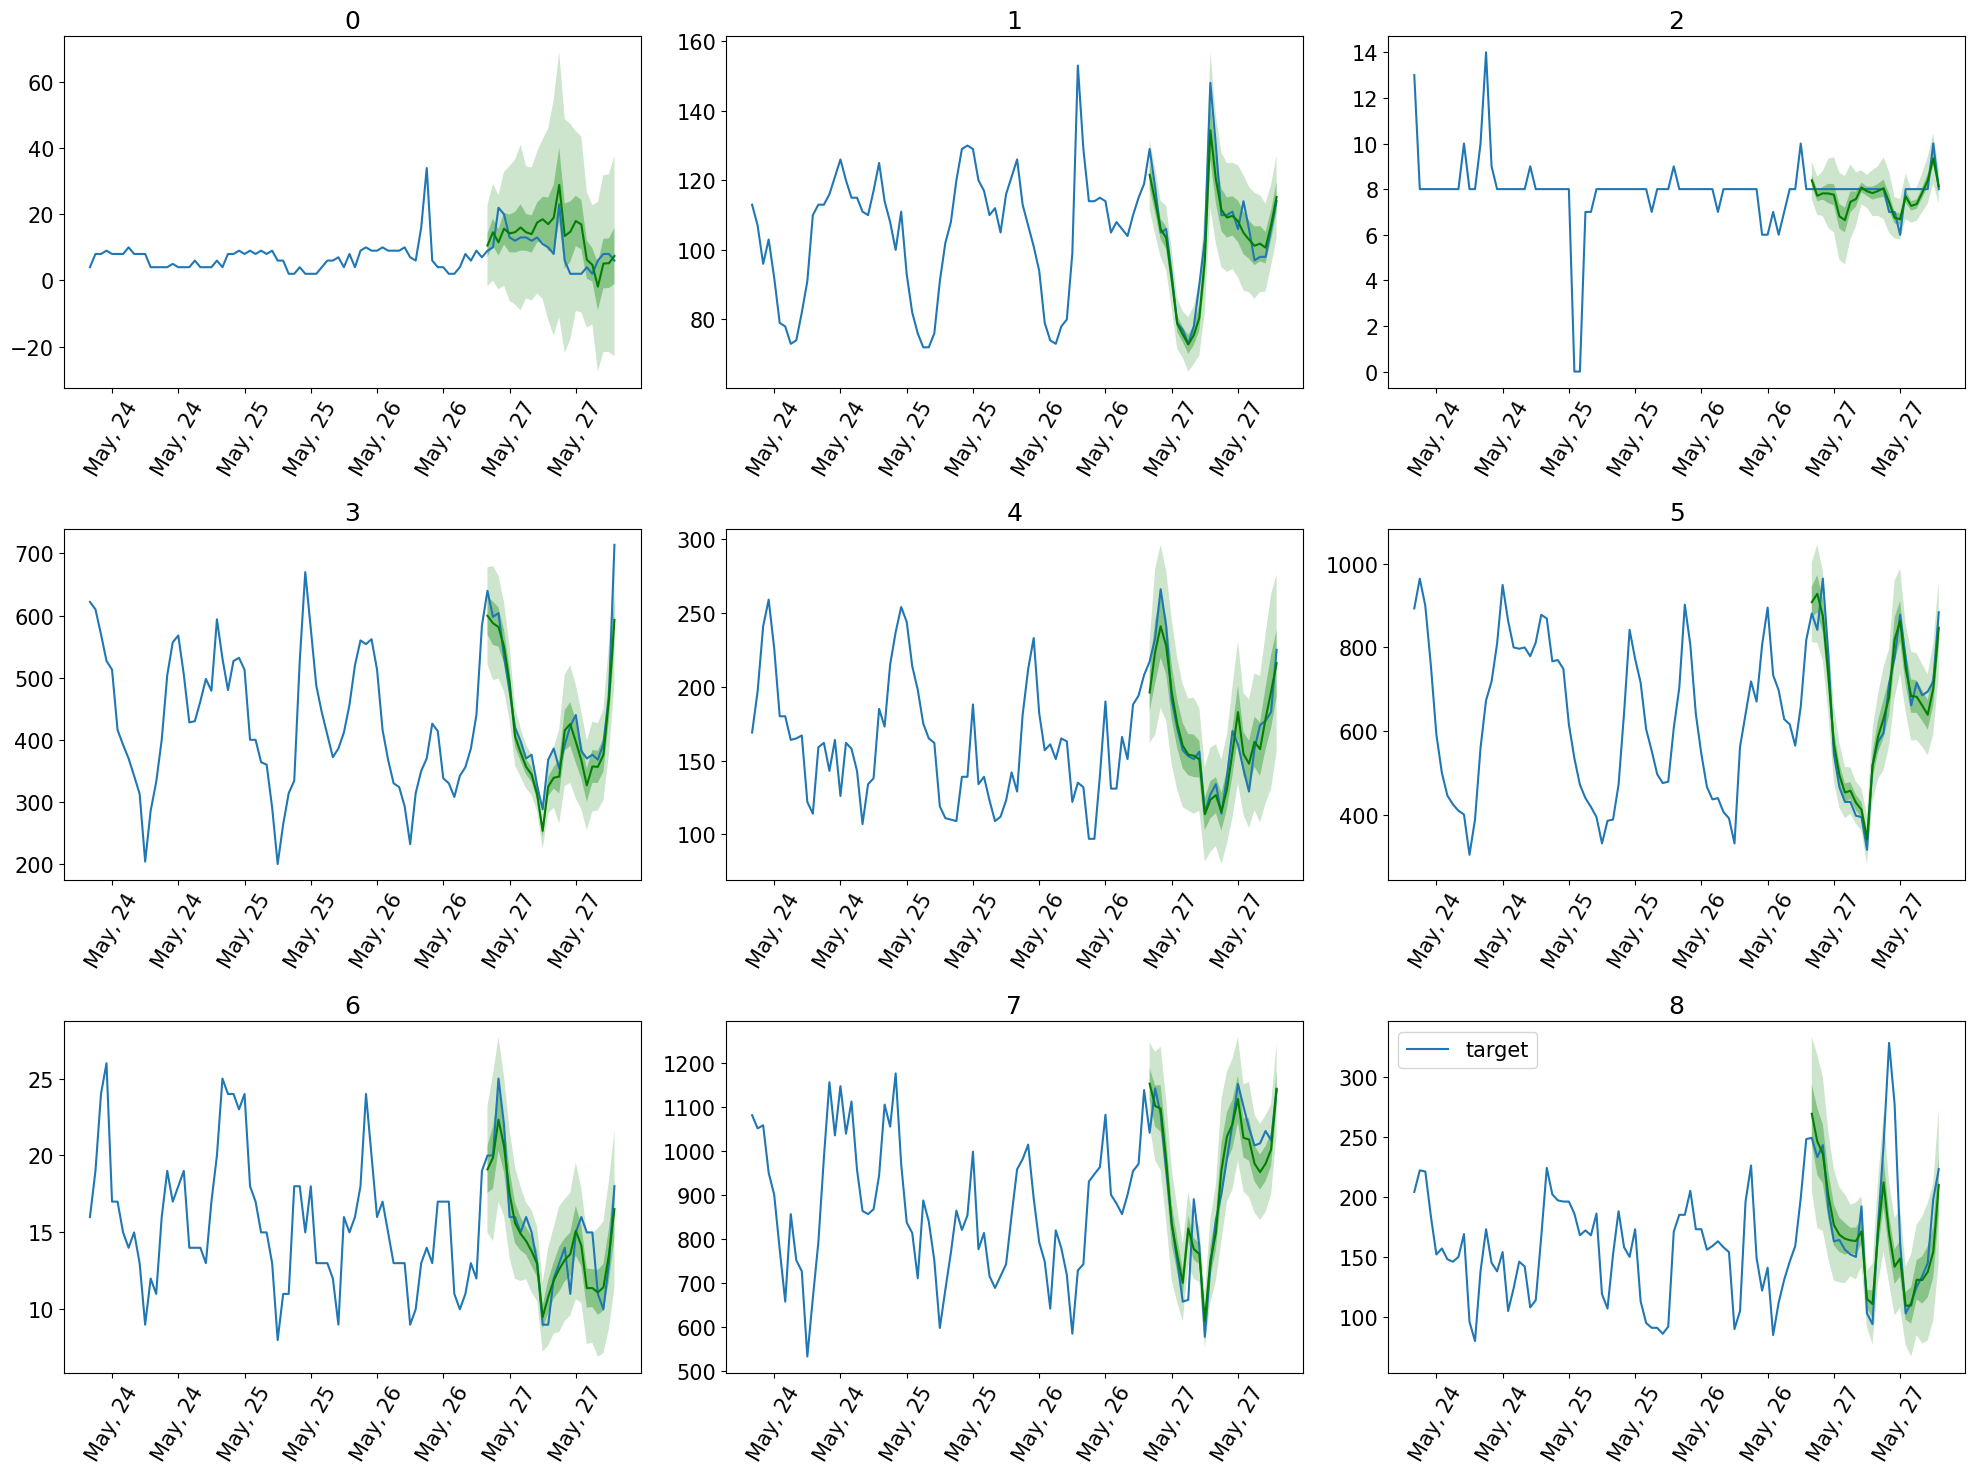

In [14]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    # Convert index for plot
    ts = ts[-4 * dataset.metadata.prediction_length:].to_timestamp()
    
    plt.plot(ts, label="target")
    forecast.plot(color='g')
    plt.xticks(rotation=60)
    plt.title(forecast.item_id)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()